Starting dataset generation...
Generating conductance variations...
Processing G_Ks...
Processing G_Kr...
Processing G_K1...
Processing G_Na...
Processing G_bNa...
Processing G_CaL...
Processing G_bCa...
Processing G_to...
Processing G_pCa...
Processing G_pK...
Total variations to simulate: 1980
Simulating standard AP...
Simulating action potentials...


100%|██████████████████████████████████████████████████████████████████████████████| 1980/1980 [28:46<00:00,  1.15it/s]


Successfully simulated 1980 action potentials
Dataset saved to ten_tusscher_dataset.pkl
Dataset Statistics:
Total action potentials: 1980
Time points per AP: 501
Ion channels: ['G_Ks', 'G_Kr', 'G_K1', 'G_Na', 'G_bNa', 'G_CaL', 'G_bCa', 'G_to', 'G_pCa', 'G_pK']

Samples per ion channel:
  G_Ks: 198
  G_Kr: 198
  G_K1: 198
  G_Na: 198
  G_bNa: 198
  G_CaL: 198
  G_bCa: 198
  G_to: 198
  G_pCa: 198
  G_pK: 198


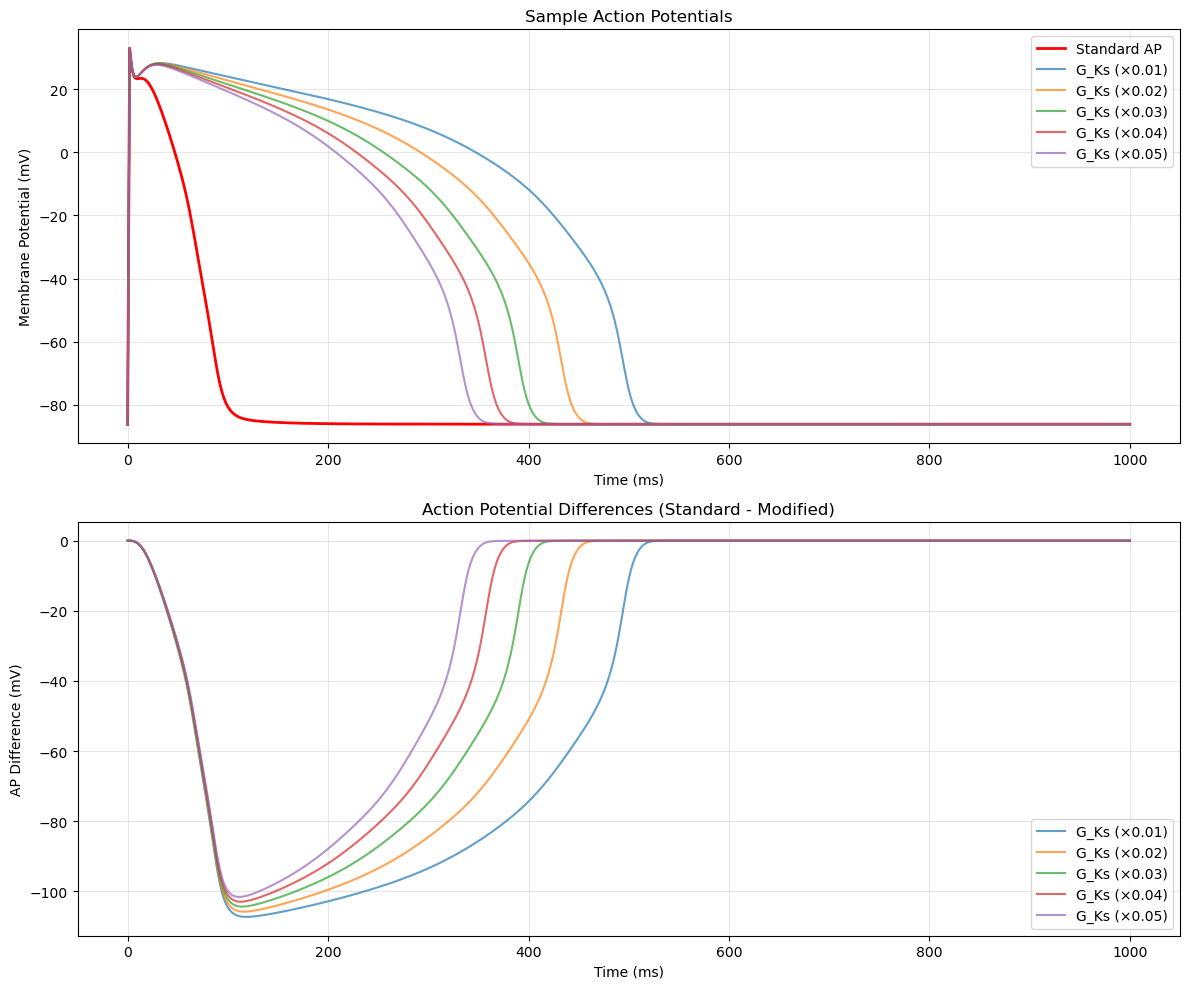

Dataset generation complete!
Use load_dataset() to load the saved data for ANN training.


In [4]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import os

class TenTusscherModel:
    """
    Ten Tusscher et al. ventricular cell model implementation
    for generating action potential dataset as described in the paper
    """
    
    def __init__(self):
        # Physical constants
        self.R = 8314.472  # J/(mol*K)
        self.T = 310.0     # K
        self.F = 96485.3415  # C/mol
        
        # Cell capacitance
        self.C_m = 0.185  # uF
        
        # Cell geometry
        self.V_c = 0.016404  # uL
        self.V_sr = 0.001094  # uL
        self.V_ss = 5.468e-5  # uL
        
        # Ion concentrations (mM)
        self.Na_o = 140.0
        self.Ca_o = 2.0
        self.K_o = 5.4
        
        # Default conductances (nS/pF) - Table 1 from paper
        self.default_conductances = {
            'G_Ks': 0.392,      # Slow delayed rectifier K+ current
            'G_Kr': 0.153,      # Rapid delayed rectifier K+ current  
            'G_K1': 5.405,      # Maximal inward K+ current
            'G_Na': 14.838,     # Maximal Na+ current
            'G_bNa': 0.00029,   # Maximal background Na+ current
            'G_CaL': 0.0000398, # Maximal L-type Ca2+ current
            'G_bCa': 0.000592,  # Maximal background Ca2+ current
            'G_to': 0.073,      # Transient outward K+ current
            'G_pCa': 0.1238,    # Maximal Ca2+ pump current
            'G_pK': 0.0146      # Maximal K+ pump current
        }
        
    def initial_conditions(self):
        """Return initial state vector for Ten Tusscher model"""
        return np.array([
            -86.2,     # V (membrane potential) [mV]
            11.6,      # Na_i [mM]
            138.3,     # K_i [mM]
            0.0002,    # Ca_i [mM]
            0.2,       # Ca_SR [mM]
            0.00036,   # Ca_ss [mM]
            0.0,       # m (Na channel activation)
            0.75,      # h (Na channel fast inactivation)
            0.75,      # j (Na channel slow inactivation)
            0.0,       # r (to channel activation)
            1.0,       # s (to channel inactivation)
            0.0,       # xs (Ks channel activation)
            0.0,       # xr1 (Kr channel activation)
            1.0,       # xr2 (Kr channel inactivation)
            0.0,       # d (CaL channel activation)
            1.0,       # f (CaL channel voltage inactivation)
            1.0,       # f2 (CaL channel Ca inactivation)
            1.0,       # fCass (CaL channel ss Ca inactivation)
            1.0,       # R_prime (RyR state)
        ])
    
    def get_reversal_potentials(self, Na_i, K_i, Ca_i):
        """Calculate reversal potentials"""
        E_Na = (self.R * self.T / self.F) * np.log(self.Na_o / Na_i)
        E_K = (self.R * self.T / self.F) * np.log(self.K_o / K_i)
        E_Ca = 0.5 * (self.R * self.T / self.F) * np.log(self.Ca_o / Ca_i)
        E_Ks = (self.R * self.T / self.F) * np.log((self.K_o + 0.03 * self.Na_o) / (K_i + 0.03 * Na_i))
        
        return E_Na, E_K, E_Ca, E_Ks
    
    def get_INa(self, V, m, h, j, Na_i, G_Na_mult=1.0):
        """Fast sodium current"""
        E_Na, _, _, _ = self.get_reversal_potentials(Na_i, 138.3, 0.0002)
        
        # Gating variables
        alpha_m = 1.0 / (1.0 + np.exp((-60.0 - V) / 5.0))
        beta_m = 0.1 / (1.0 + np.exp((V + 35.0) / 5.0)) + 0.10 / (1.0 + np.exp((V - 50.0) / 200.0))
        tau_m = alpha_m * beta_m
        m_inf = 1.0 / (1.0 + np.exp((-56.86 - V) / 9.03))**2
        dm_dt = (m_inf - m) / tau_m
        
        if V >= -40.0:
            alpha_h = 0.0
            beta_h = 0.77 / (0.13 * (1.0 + np.exp(-(V + 10.66) / 11.1)))
        else:
            alpha_h = 0.057 * np.exp(-(V + 80.0) / 6.8)
            beta_h = 2.7 * np.exp(0.079 * V) + 3.1e5 * np.exp(0.3485 * V)
        
        tau_h = 1.0 / (alpha_h + beta_h)
        h_inf = 1.0 / (1.0 + np.exp((V + 71.55) / 7.43))**2
        dh_dt = (h_inf - h) / tau_h
        
        if V >= -40.0:
            alpha_j = 0.0
            beta_j = 0.6 * np.exp(0.057 * V) / (1.0 + np.exp(-0.1 * (V + 32.0)))
        else:
            alpha_j = (-2.5428e4 * np.exp(0.2444 * V) - 6.948e-6 * np.exp(-0.04391 * V)) * (V + 37.78) / (1.0 + np.exp(0.311 * (V + 79.23)))
            beta_j = 0.02424 * np.exp(-0.01052 * V) / (1.0 + np.exp(-0.1378 * (V + 40.14)))
        
        tau_j = 1.0 / (alpha_j + beta_j)
        j_inf = 1.0 / (1.0 + np.exp((V + 71.55) / 7.43))**2
        dj_dt = (j_inf - j) / tau_j
        
        G_Na = self.default_conductances['G_Na'] * G_Na_mult
        I_Na = G_Na * m**3 * h * j * (V - E_Na)
        
        return I_Na, dm_dt, dh_dt, dj_dt
    
    def get_Ito(self, V, r, s, G_to_mult=1.0):
        """Transient outward K+ current"""
        _, E_K, _, _ = self.get_reversal_potentials(11.6, 138.3, 0.0002)
        
        r_inf = 1.0 / (1.0 + np.exp((20.0 - V) / 6.0))
        tau_r = 9.5 * np.exp(-(V + 40.0)**2 / 1800.0) + 0.8
        dr_dt = (r_inf - r) / tau_r
        
        s_inf = 1.0 / (1.0 + np.exp((V + 20.0) / 5.0))
        tau_s = 85.0 * np.exp(-(V + 45.0)**2 / 320.0) + 5.0 / (1.0 + np.exp((V - 20.0) / 5.0)) + 3.0
        ds_dt = (s_inf - s) / tau_s
        
        G_to = self.default_conductances['G_to'] * G_to_mult
        I_to = G_to * r * s * (V - E_K)
        
        return I_to, dr_dt, ds_dt
    
    def get_IKr(self, V, xr1, xr2, G_Kr_mult=1.0):
        """Rapid delayed rectifier K+ current"""
        _, E_K, _, _ = self.get_reversal_potentials(11.6, 138.3, 0.0002)
        
        alpha_xr1 = 450.0 / (1.0 + np.exp((-45.0 - V) / 10.0))
        beta_xr1 = 6.0 / (1.0 + np.exp((V + 30.0) / 11.5))
        tau_xr1 = 1.0 / (alpha_xr1 + beta_xr1)
        xr1_inf = 1.0 / (1.0 + np.exp((-26.0 - V) / 7.0))
        dxr1_dt = (xr1_inf - xr1) / tau_xr1
        
        alpha_xr2 = 3.0 / (1.0 + np.exp((-60.0 - V) / 20.0))
        beta_xr2 = 1.12 / (1.0 + np.exp((V - 60.0) / 20.0))
        tau_xr2 = 1.0 / (alpha_xr2 + beta_xr2)
        xr2_inf = 1.0 / (1.0 + np.exp((V + 88.0) / 24.0))
        dxr2_dt = (xr2_inf - xr2) / tau_xr2
        
        G_Kr = self.default_conductances['G_Kr'] * G_Kr_mult * np.sqrt(self.K_o / 5.4)
        I_Kr = G_Kr * xr1 * xr2 * (V - E_K)
        
        return I_Kr, dxr1_dt, dxr2_dt
    
    def get_IKs(self, V, xs, G_Ks_mult=1.0):
        """Slow delayed rectifier K+ current"""
        _, _, _, E_Ks = self.get_reversal_potentials(11.6, 138.3, 0.0002)
        
        alpha_xs = 1400.0 / np.sqrt(1.0 + np.exp((5.0 - V) / 6.0))
        beta_xs = 1.0 / (1.0 + np.exp((V - 35.0) / 15.0))
        tau_xs = 1.0 / (alpha_xs + beta_xs) + 80.0
        xs_inf = 1.0 / (1.0 + np.exp((-5.0 - V) / 14.0))
        dxs_dt = (xs_inf - xs) / tau_xs
        
        G_Ks = self.default_conductances['G_Ks'] * G_Ks_mult
        I_Ks = G_Ks * xs**2 * (V - E_Ks)
        
        return I_Ks, dxs_dt
    
    def get_IK1(self, V, K_i, G_K1_mult=1.0):
        """Inward rectifier K+ current"""
        _, E_K, _, _ = self.get_reversal_potentials(11.6, K_i, 0.0002)
        
        alpha_K1 = 0.1 / (1.0 + np.exp(0.06 * (V - E_K - 200.0)))
        beta_K1 = (3.0 * np.exp(0.0002 * (V - E_K + 100.0)) + 
                   np.exp(0.1 * (V - E_K - 10.0))) / (1.0 + np.exp(-0.5 * (V - E_K)))
        K1_inf = alpha_K1 / (alpha_K1 + beta_K1)
        
        G_K1 = self.default_conductances['G_K1'] * G_K1_mult * np.sqrt(self.K_o / 5.4)
        I_K1 = G_K1 * K1_inf * (V - E_K)
        
        return I_K1
    
    def get_ICaL(self, V, d, f, f2, fCass, Ca_i, Ca_ss, G_CaL_mult=1.0):
        """L-type calcium current"""
        _, _, E_Ca, _ = self.get_reversal_potentials(11.6, 138.3, Ca_i)
        
        d_inf = 1.0 / (1.0 + np.exp((-8.0 - V) / 7.5))
        alpha_d = 1.4 / (1.0 + np.exp((-35.0 - V) / 13.0)) + 0.25
        beta_d = 1.4 / (1.0 + np.exp((V + 5.0) / 5.0))
        gamma_d = 1.0 / (1.0 + np.exp((50.0 - V) / 20.0))
        tau_d = alpha_d * beta_d + gamma_d
        dd_dt = (d_inf - d) / tau_d
        
        f_inf = 1.0 / (1.0 + np.exp((V + 20.0) / 7.0))
        tau_f = 1102.5 * np.exp(-((V + 27.0) / 15.0)**2) + 200.0 / (1.0 + np.exp((13.0 - V) / 10.0)) + 180.0 / (1.0 + np.exp((V + 30.0) / 10.0)) + 20.0
        df_dt = (f_inf - f) / tau_f
        
        f2_inf = 0.67 / (1.0 + np.exp((V + 35.0) / 7.0)) + 0.33
        tau_f2 = 562.0 * np.exp(-((V + 27.0) / 240.0)**2) + 31.0 / (1.0 + np.exp((25.0 - V) / 10.0)) + 80.0 / (1.0 + np.exp((V + 30.0) / 10.0))
        df2_dt = (f2_inf - f2) / tau_f2
        
        fCass_inf = 0.6 / (1.0 + (Ca_ss / 0.05)**2) + 0.4
        tau_fCass = 80.0 / (1.0 + (Ca_ss / 0.05)**2) + 2.0
        dfCass_dt = (fCass_inf - fCass) / tau_fCass
        
        G_CaL = self.default_conductances['G_CaL'] * G_CaL_mult
        I_CaL = G_CaL * d * f * f2 * fCass * 4.0 * (V * self.F**2) / (self.R * self.T) * \
                (Ca_ss * np.exp(2.0 * V * self.F / (self.R * self.T)) - 0.341 * self.Ca_o) / \
                (np.exp(2.0 * V * self.F / (self.R * self.T)) - 1.0)
        
        return I_CaL, dd_dt, df_dt, df2_dt, dfCass_dt
    
    def get_background_currents(self, V, Na_i, Ca_i, G_bNa_mult=1.0, G_bCa_mult=1.0):
        """Background Na+ and Ca2+ currents"""
        E_Na, _, E_Ca, _ = self.get_reversal_potentials(Na_i, 138.3, Ca_i)
        
        G_bNa = self.default_conductances['G_bNa'] * G_bNa_mult
        I_bNa = G_bNa * (V - E_Na)
        
        G_bCa = self.default_conductances['G_bCa'] * G_bCa_mult
        I_bCa = G_bCa * (V - E_Ca)
        
        return I_bNa, I_bCa
    
    def get_pump_currents(self, V, Na_i, K_i, Ca_i, G_pK_mult=1.0, G_pCa_mult=1.0):
        """Pump currents"""
        _, E_K, _, _ = self.get_reversal_potentials(Na_i, K_i, Ca_i)
        
        # K+ pump
        G_pK = self.default_conductances['G_pK'] * G_pK_mult
        I_pK = G_pK * (V - E_K) / (1.0 + np.exp((25.0 - V) / 5.98))
        
        # Ca2+ pump
        G_pCa = self.default_conductances['G_pCa'] * G_pCa_mult
        I_pCa = G_pCa * Ca_i / (0.0005 + Ca_i)
        
        return I_pK, I_pCa
    
    def model_equations(self, t, y, conductance_multipliers):
        """System of differential equations"""
        # Unpack state variables
        V, Na_i, K_i, Ca_i, Ca_SR, Ca_ss, m, h, j, r, s, xs, xr1, xr2, d, f, f2, fCass, R_prime = y
        
        # Get conductance multipliers
        G_Na_mult = conductance_multipliers.get('G_Na', 1.0)
        G_Kr_mult = conductance_multipliers.get('G_Kr', 1.0)
        G_Ks_mult = conductance_multipliers.get('G_Ks', 1.0)
        G_K1_mult = conductance_multipliers.get('G_K1', 1.0)
        G_to_mult = conductance_multipliers.get('G_to', 1.0)
        G_CaL_mult = conductance_multipliers.get('G_CaL', 1.0)
        G_bNa_mult = conductance_multipliers.get('G_bNa', 1.0)
        G_bCa_mult = conductance_multipliers.get('G_bCa', 1.0)
        G_pK_mult = conductance_multipliers.get('G_pK', 1.0)
        G_pCa_mult = conductance_multipliers.get('G_pCa', 1.0)
        
        # Calculate currents
        I_Na, dm_dt, dh_dt, dj_dt = self.get_INa(V, m, h, j, Na_i, G_Na_mult)
        I_to, dr_dt, ds_dt = self.get_Ito(V, r, s, G_to_mult)
        I_Kr, dxr1_dt, dxr2_dt = self.get_IKr(V, xr1, xr2, G_Kr_mult)
        I_Ks, dxs_dt = self.get_IKs(V, xs, G_Ks_mult)
        I_K1 = self.get_IK1(V, K_i, G_K1_mult)
        I_CaL, dd_dt, df_dt, df2_dt, dfCass_dt = self.get_ICaL(V, d, f, f2, fCass, Ca_i, Ca_ss, G_CaL_mult)
        I_bNa, I_bCa = self.get_background_currents(V, Na_i, Ca_i, G_bNa_mult, G_bCa_mult)
        I_pK, I_pCa = self.get_pump_currents(V, Na_i, K_i, Ca_i, G_pK_mult, G_pCa_mult)
        
        # Simplified calcium handling and other currents
        I_NaCa = 0.0  # Simplified
        I_NaK = 0.0   # Simplified
        I_rel = 0.0   # Simplified
        I_up = 0.0    # Simplified
        I_leak = 0.0  # Simplified
        
        # Stimulus current
        I_stim = 0.0
        if 0 <= t <= 1.0:  # 1ms stimulus
            I_stim = -52.0  # pA/pF
        
        # Total ionic current
        I_ion = (I_Na + I_to + I_Kr + I_Ks + I_K1 + I_CaL + I_NaCa + I_NaK + 
                I_pCa + I_pK + I_bCa + I_bNa)
        
        # Membrane potential
        dV_dt = -(I_ion + I_stim)
        
        # Ion concentrations (simplified)
        dNa_i_dt = 0.0
        dK_i_dt = 0.0
        dCa_i_dt = 0.0
        dCa_SR_dt = 0.0
        dCa_ss_dt = 0.0
        dR_prime_dt = 0.0
        
        return [dV_dt, dNa_i_dt, dK_i_dt, dCa_i_dt, dCa_SR_dt, dCa_ss_dt,
                dm_dt, dh_dt, dj_dt, dr_dt, ds_dt, dxs_dt, dxr1_dt, dxr2_dt,
                dd_dt, df_dt, df2_dt, dfCass_dt, dR_prime_dt]
    
    def simulate_ap(self, conductance_multipliers=None, duration=1000.0, dt=2.0):
        """Simulate action potential"""
        if conductance_multipliers is None:
            conductance_multipliers = {}
        
        # Time points
        t_span = (0, duration)
        t_eval = np.arange(0, duration + dt, dt)
        
        # Initial conditions
        y0 = self.initial_conditions()
        
        # Solve ODE
        sol = solve_ivp(
            lambda t, y: self.model_equations(t, y, conductance_multipliers),
            t_span, y0, t_eval=t_eval, method='LSODA', rtol=1e-6
        )
        
        return sol.t, sol.y[0]  # Return time and membrane potential

def generate_dataset():
    """Generate the complete dataset as described in the paper"""
    
    model = TenTusscherModel()
    
    # Ion channels to vary (exactly 10 as in paper)
    ion_channels = ['G_Ks', 'G_Kr', 'G_K1', 'G_Na', 'G_bNa', 
                   'G_CaL', 'G_bCa', 'G_to', 'G_pCa', 'G_pK']
    
    # Generate variations: 0.01 to 0.99 (decrease) and 1.01 to 1.99 (increase)
    # Each channel: 99 decrease + 99 increase = 198 variations
    # Total: 10 channels × 198 variations = 1980 APs
    
    multipliers = []
    labels = []
    channel_names = []
    
    print("Generating conductance variations...")
    
    for i, channel in enumerate(ion_channels):
        print(f"Processing {channel}...")
        
        # Decrease conductance: 0.01 to 0.99
        for mult in np.arange(0.01, 1.0, 0.01):
            multipliers.append({channel: mult})
            labels.append(i)
            channel_names.append(channel)
        
        # Increase conductance: 1.01 to 1.99  
        for mult in np.arange(1.01, 2.0, 0.01):
            multipliers.append({channel: mult})
            labels.append(i)
            channel_names.append(channel)
    
    print(f"Total variations to simulate: {len(multipliers)}")
    
    # Simulate standard AP (no changes)
    print("Simulating standard AP...")
    t_std, v_std = model.simulate_ap()
    
    # Store all APs and differences
    all_aps = []
    ap_differences = []
    all_labels = []
    all_channels = []
    all_multipliers = []
    
    print("Simulating action potentials...")
    
    for i, (mult_dict, label, channel) in enumerate(tqdm(zip(multipliers, labels, channel_names), 
                                                          total=len(multipliers))):
        try:
            # Simulate AP with modified conductance
            t, v = model.simulate_ap(mult_dict)
            
            # Calculate AP difference (standard - modified)
            ap_diff = v_std - v
            
            # Store data
            all_aps.append(v)
            ap_differences.append(ap_diff)
            all_labels.append(label)
            all_channels.append(channel)
            all_multipliers.append(list(mult_dict.values())[0])
            
        except Exception as e:
            print(f"Error simulating {channel} with multiplier {mult_dict}: {e}")
            continue
    
    print(f"Successfully simulated {len(all_aps)} action potentials")
    
    # Create dataset
    dataset = {
        'time': t_std,
        'standard_ap': v_std,
        'action_potentials': np.array(all_aps),
        'ap_differences': np.array(ap_differences),
        'labels': np.array(all_labels),
        'channel_names': all_channels,
        'multipliers': all_multipliers,
        'ion_channels': ion_channels
    }
    
    return dataset

def save_dataset(dataset, filename='ten_tusscher_dataset.pkl'):
    """Save dataset to file"""
    with open(filename, 'wb') as f:
        pickle.dump(dataset, f)
    print(f"Dataset saved to {filename}")

def load_dataset(filename='ten_tusscher_dataset.pkl'):
    """Load dataset from file"""
    with open(filename, 'rb') as f:
        dataset = pickle.load(f)
    return dataset

def plot_sample_aps(dataset, n_samples=5):
    """Plot sample action potentials and differences"""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Plot standard AP
    ax1.plot(dataset['time'], dataset['standard_ap'], 'r-', linewidth=2, label='Standard AP')
    
    # Plot sample modified APs
    for i in range(min(n_samples, len(dataset['action_potentials']))):
        channel = dataset['channel_names'][i]
        mult = dataset['multipliers'][i]
        ax1.plot(dataset['time'], dataset['action_potentials'][i], 
                label=f'{channel} (×{mult:.2f})', alpha=0.7)
    
    ax1.set_xlabel('Time (ms)')
    ax1.set_ylabel('Membrane Potential (mV)')
    ax1.set_title('Sample Action Potentials')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot AP differences
    for i in range(min(n_samples, len(dataset['ap_differences']))):
        channel = dataset['channel_names'][i]
        mult = dataset['multipliers'][i]
        ax2.plot(dataset['time'], dataset['ap_differences'][i], 
                label=f'{channel} (×{mult:.2f})', alpha=0.7)
    
    ax2.set_xlabel('Time (ms)')
    ax2.set_ylabel('AP Difference (mV)')
    ax2.set_title('Action Potential Differences (Standard - Modified)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def get_statistics(dataset):
    """Get dataset statistics"""
    print("Dataset Statistics:")
    print(f"Total action potentials: {len(dataset['action_potentials'])}")
    print(f"Time points per AP: {len(dataset['time'])}")
    print(f"Ion channels: {dataset['ion_channels']}")
    
    # Count samples per channel
    unique_labels, counts = np.unique(dataset['labels'], return_counts=True)
    print("\nSamples per ion channel:")
    for label, count in zip(unique_labels, counts):
        print(f"  {dataset['ion_channels'][label]}: {count}")

if __name__ == "__main__":
    print("Starting dataset generation...")
    
    # Generate dataset
    dataset = generate_dataset()
    
    # Save dataset
    save_dataset(dataset)
    
    # Show statistics
    get_statistics(dataset)
    
    # Plot samples
    plot_sample_aps(dataset)
    
    print("Dataset generation complete!")
    print("Use load_dataset() to load the saved data for ANN training.")

In [5]:
load_dataset()

{'time': array([   0.,    2.,    4.,    6.,    8.,   10.,   12.,   14.,   16.,
          18.,   20.,   22.,   24.,   26.,   28.,   30.,   32.,   34.,
          36.,   38.,   40.,   42.,   44.,   46.,   48.,   50.,   52.,
          54.,   56.,   58.,   60.,   62.,   64.,   66.,   68.,   70.,
          72.,   74.,   76.,   78.,   80.,   82.,   84.,   86.,   88.,
          90.,   92.,   94.,   96.,   98.,  100.,  102.,  104.,  106.,
         108.,  110.,  112.,  114.,  116.,  118.,  120.,  122.,  124.,
         126.,  128.,  130.,  132.,  134.,  136.,  138.,  140.,  142.,
         144.,  146.,  148.,  150.,  152.,  154.,  156.,  158.,  160.,
         162.,  164.,  166.,  168.,  170.,  172.,  174.,  176.,  178.,
         180.,  182.,  184.,  186.,  188.,  190.,  192.,  194.,  196.,
         198.,  200.,  202.,  204.,  206.,  208.,  210.,  212.,  214.,
         216.,  218.,  220.,  222.,  224.,  226.,  228.,  230.,  232.,
         234.,  236.,  238.,  240.,  242.,  244.,  246.,  248.,  250.

In [7]:
data=dataset['ap_differences']

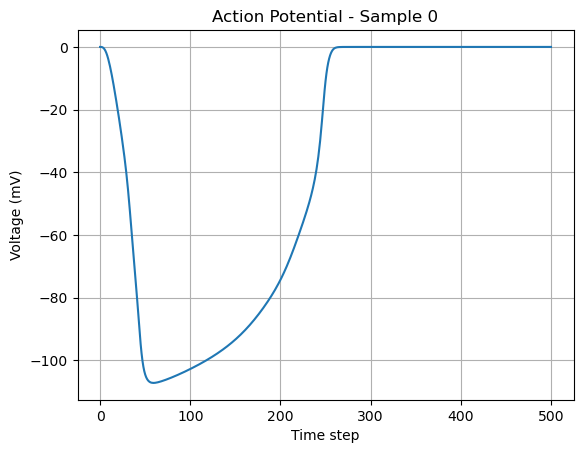

In [12]:
np.set_printoptions(threshold=np.inf)
data.shape
plt.plot(data[0])
plt.title("Action Potential - Sample 0")
plt.xlabel("Time step")
plt.ylabel("Voltage (mV)")
plt.grid(True)
plt.show()

In [21]:
channels = ['GNa', 'GKr', 'GKs', 'Gto', 'GK1', 'GCaL', 'GbNa', 'GbCa', 'GpK', 'GpCa']
labels = []

for ch in channels:
    labels.extend([ch] * 198)

# Verify length
print("Labels:", len(labels))  # Should be 1980


Labels: 1980


In [22]:
df = pd.DataFrame(data)
df['channel'] = labels
df.to_csv("ap_dataset_labeled.csv", index=False)

In [24]:
data=pd.read_csv('ap_dataset_labeled.csv')
data

,0,1,2,3,4,5,6,7,8,9,...,492,493,494,495,496,497,498,499,500,channel
0,0.0,-0.002432,-0.044127,-0.168850,-0.404639,-0.773205,-1.290878,-1.967325,-2.804175,-3.795185,...,1.060049e-03,1.055896e-03,1.051771e-03,1.047676e-03,1.043609e-03,0.001040,0.001036,0.001032,0.001028,GNa
1,0.0,-0.002408,-0.043682,-0.167142,-0.400537,-0.765338,-1.277670,-1.947037,-2.774963,-3.755146,...,8.714939e-04,8.683297e-04,8.651874e-04,8.620671e-04,8.589685e-04,0.000856,0.000853,0.000850,0.000847,GNa
2,0.0,-0.002385,-0.043237,-0.165435,-0.396436,-0.757471,-1.264464,-1.926759,-2.745770,-3.715146,...,7.552828e-04,7.527204e-04,7.501869e-04,7.476833e-04,7.452114e-04,0.000743,0.000740,0.000738,0.000736,GNa
3,0.0,-0.002301,-0.042753,-0.163701,-0.392315,-0.749590,-1.251251,-1.906479,-2.716589,-3.675181,...,6.761228e-04,6.741544e-04,6.721797e-04,6.702074e-04,6.682260e-04,0.000666,0.000664,0.000662,0.000660,GNa
4,0.0,-0.002338,-0.042347,-0.162020,-0.388233,-0.741742,-1.238065,-1.886229,-2.687443,-3.635262,...,6.132600e-04,6.116717e-04,6.102570e-04,6.090416e-04,6.080535e-04,0.000607,0.000607,0.000607,0.000605,GNa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1975,0.0,1.098678,2.286103,2.583387,2.690380,2.777422,2.865207,2.936723,2.969902,2.948981,...,1.021853e-06,1.155975e-06,1.242497e-06,1.333977e-06,1.424657e-06,0.000002,0.000002,0.000002,0.000002,GpCa
1976,0.0,1.109934,2.307669,2.606190,2.713114,2.800222,2.888272,2.960047,2.993270,2.972047,...,1.347513e-06,1.331165e-06,1.320712e-06,1.316883e-06,1.320442e-06,0.000001,0.000001,0.000001,0.000001,GpCa
1977,0.0,1.121183,2.329188,2.628915,2.735754,2.822920,2.911228,2.983256,3.016522,2.994997,...,1.509715e-06,1.511124e-06,1.515017e-06,1.521571e-06,1.530969e-06,0.000002,0.000002,0.000002,0.000001,GpCa
1978,0.0,1.132426,2.350658,2.651563,2.758301,2.845515,2.934075,3.006353,3.039659,3.017833,...,7.954999e-07,7.776499e-07,7.985281e-07,8.632145e-07,9.769840e-07,0.000001,0.000001,0.000001,0.000001,GpCa
